<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/6_Machine_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial steps

In [ ]:
# importing the needed packages
!pip install transformers &> /dev/null
!pip install yfinance &> /dev/null
!pip install bert-for-tf2 &> /dev/null
import bert
import os
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from datetime import datetime
nltk.download('wordnet')
warnings.filterwarnings('ignore')
from collections import Counter
import itertools
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from keras import backend as K
from transformers import BertTokenizer
import torch
import re
import tensorflow as tf

# 1 Preparing data for the models

## 1.1 Cleaning and exploring the sentiment analysis dataset

In [ ]:
# loading in the dataframe for sentiment analysis
sent_df = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/sentiment_data.csv", header = 0, names = ["sentiment", "title"], encoding = "latin-1")

In [ ]:
# inspecting the dataframe
sent_df.head()

In [ ]:
# inspecting the classes
# they are rather unbalanced
plt.figure(figsize=(12,8))
sns.barplot(x=pd.DataFrame(sent_df["sentiment"].value_counts()).index,y=pd.DataFrame(sent_df["sentiment"].value_counts())["sentiment"], palette = "winter")
plt.show()

In [ ]:
# initiating a lemmatizer instance
lemmatizer = WordNetLemmatizer()
# making a list of stopwords
stop_words = set(stopwords.words('english'))
# making a function that lemmatizes the titles and then puts them together
def sneaky_cleanup(title):
  tokens = []
  for token in title.split():
    if token not in stop_words:
      if token.isalnum():
        tokens.append(lemmatizer.lemmatize(token))
  return " ".join(tokens)

In [ ]:
# applying the lemmatizer to each row of the dataframe
sent_df.title = sent_df.title.apply(lambda x: sneaky_cleanup(x))
sent_df.head()

We decided that cleaning up the text before applying a machine learning model would be beneficial. We lemmatized the words, removed the stopwords and interpunctions.

We chose lemmatization over stemming as it preserves the original meaning of a word better - lemmatiztion changes the word to its lemma (base of the word), whereas stemming simply cuts off the ending.

The stopwords and interpunctions were removed despite their potential importance for the context, as they typically don't improve performance in the case of sentiment analysis, as the model only needs to classify the titles into the category of positive, negative and neutral ones.


In [ ]:
# creating three new dataframes for the three sentiments
sent_pos=sent_df[sent_df["sentiment"] == "positive"]
sent_neg=sent_df[sent_df["sentiment"] == "negative"]
sent_neu=sent_df[sent_df["sentiment"] == "neutral"]
# tokenizing the titles in the dataframes
sent_pos["title"]=sent_pos["title"].apply(lambda x: word_tokenize(x))
sent_neg["title"]=sent_neg["title"].apply(lambda x: word_tokenize(x))
sent_neu["title"]=sent_neu["title"].apply(lambda x: word_tokenize(x))

In [ ]:
# finding the most popular words in the negative titles
Counter(itertools.chain(*sent_neg["title"])).most_common(10)

In [ ]:
# finding the most popular words in the neutral titles
Counter(itertools.chain(*sent_neu["title"])).most_common(10)

In [ ]:
# finding the most popular words in the positive titles
Counter(itertools.chain(*sent_pos["title"])).most_common(10)

As can be seen, the words in all the titles are very similar, showing how difficult the task of predicting the sentiment will be.

In [ ]:
# inspecting the length of the titles - the longest title is just above 40 words
sent_df["words"] = sent_df["title"].map(lambda x: len(x.split()))
sent_df["words"].describe()

In [ ]:
# creating a series of all the sentiments
y = sent_df["sentiment"]
# creating a labelencoder instance
labelencoder_y = LabelEncoder()
# encoding the sentiments
y = labelencoder_y.fit_transform(y)
# changing the sentiments to one-hot encoding
y = np_utils.to_categorical(y)

In [ ]:
# creating training and testing samples
X_train, X_test, y_train, y_test = train_test_split(sent_df["title"], y, test_size = 0.2, random_state = 44)
X_test_initial = X_test

## 1.2 Preparing the dataset for transformers use and creating transformers layer

In [ ]:
# initiating a bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# using a slightly modified pre-made function that partially processes the data for bert
# the function runs on torch, not tensorflow, so the outputs will need to be turned into numpy arrays
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Specifying MAX_LEN based on the previuously inspected title length
MAX_LEN = 40

# Run function preprocessing_for_bert on the train set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

In [ ]:
# creating id columns based on the index
train_ids = torch.tensor(X_train.index.tolist())
test_ids = torch.tensor(X_test.index.tolist())

In [ ]:
# turning the torch tensors into numpy arrays of the required type
train_inputs = train_inputs.numpy().astype("int32")
train_masks = train_masks.numpy().astype("int32")
train_ids = train_ids.numpy().astype("int32")
val_inputs = val_inputs.numpy().astype("int32")
val_masks = val_masks.numpy().astype("int32")
test_ids = test_ids.numpy().astype("int32")

In [ ]:
# putting the id, mask and tensor in a dictionary
X_train_dic = {"input_word_ids":train_inputs,"input_mask":train_masks,"input_type_ids":train_ids}
X_test_dic = {"input_word_ids":val_inputs,"input_mask":val_masks,"input_type_ids":test_ids}

In [ ]:
# importing bert for tf2
bert_v2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True, output_key="pooled_output")

## 1.3 Creating the sentiment analysis model

In [ ]:
# creating a model
model = Sequential()
model.add(bert_v2)
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(264, activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
# changing the learning rate to a much lower rate
# it makes the results vastly more stable
opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
# defining a custom loss function
def weighted_categorical_crossentropy(weights):

    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calculate
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
# calculating the fraction of the dataset for each class
perc_neu = sent_df[sent_df["sentiment"]=="neutral"]["sentiment"].count()/sent_df["sentiment"].count()
perc_pos = sent_df[sent_df["sentiment"]=="positive"]["sentiment"].count()/sent_df["sentiment"].count()
perc_neg = sent_df[sent_df["sentiment"]=="negative"]["sentiment"].count()/sent_df["sentiment"].count()

In [ ]:
# choosing the weights - those seemed to present the best results
weights = np.array([2,1,2-perc_pos])

In [ ]:
model.compile(optimizer = opt, loss=weighted_categorical_crossentropy(weights), metrics=['accuracy'])

In [ ]:
# batch size and number of epochs chosen based on the best results
history = model.fit(X_train_dic, y_train, batch_size=64, epochs = 10)

Epoch 1/10
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


61/61 [==============================] - 73s 912ms/step - loss: 1.3239 - accuracy: 0.5604
Epoch 2/10
61/61 [==============================] - 56s 919ms/step - loss: 0.7904 - accuracy: 0.7908
Epoch 3/10
61/61 [==============================] - 56s 922ms/step - loss: 0.5128 - accuracy: 0.8797
Epoch 4/10
61/61 [==============================] - 56s 921ms/step - loss: 0.3944 - accuracy: 0.9043
Epoch 5/10
61/61 [==============================] - 56s 922ms/step - loss: 0.2255 - accuracy: 0.9470
Epoch 6/10
61/61 [==============================] - 56s 920ms/step - loss: 0.1907 - accuracy: 0.9610
Epoch 7/10
61/61 [==============================] - 56s 920ms/step - loss: 0.1568 - accuracy: 0.9645
Epoch 8/10
61/61 [==============================] - 56s 919ms/step - loss: 0.1602 - accuracy: 0.9609
Epoch 9/10
61/61 [==============================] - 56s 919ms/step - loss: 0.1786 - accuracy: 0.9599
Epoch 10/10
61/61 [==============================] - 56s 920ms/step - loss: 0.1264 - accuracy: 0.9726


## 1.4 Evaluation of the sentiment model

In [ ]:
# evaluating the accuracy on the test set - close to 80%
model.evaluate(X_test_dic, y_test)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


31/31 [==============================] - 6s 160ms/step - loss: 1.0933 - accuracy: 0.7833


[1.0933244228363037, 0.7832817435264587]

In [ ]:
# finding the predictions
y_pred = model.predict(X_test_dic)
y_pred_hardmax = np.zeros_like(y_pred)
y_pred_hardmax[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


In [ ]:
# changing back from one hot encoding to a list of classes
y_pred_hardmax= [np.argmax(y, axis=None, out=None) for y in y_pred_hardmax]
y_test= [np.argmax(y, axis=None, out=None) for y in y_test]
# reversing the encoding
y_test = labelencoder_y.inverse_transform(y_test)
y_pred_hardmax = labelencoder_y.inverse_transform(y_pred_hardmax)

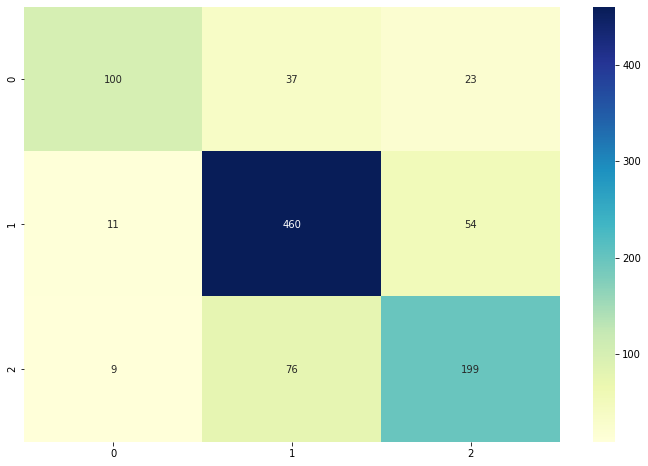

In [ ]:
# creating a confusion matrix - it looks rather well
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_pred_hardmax,y_test), annot = True, cmap = "YlGnBu",fmt='g')

In [ ]:
# printing out the classification report
print(classification_report(y_pred_hardmax,y_test))

              precision    recall  f1-score   support

    negative       0.83      0.62      0.71       160
     neutral       0.80      0.88      0.84       525
    positive       0.72      0.70      0.71       284

    accuracy                           0.78       969
   macro avg       0.79      0.73      0.75       969
weighted avg       0.78      0.78      0.78       969



In [ ]:
# creating aand cleaning a dataframe from X_test
X_test_initial = pd.DataFrame(X_test_initial)
X_test_initial = X_test_initial.reset_index()
X_test_initial = X_test_initial.loc[:,"title"]
X_test_initial = pd.DataFrame(X_test_initial)

In [ ]:
# creating and cleaning a dataframe from y_test
y_test = pd.DataFrame(y_test)
# creating a dataframe from the label predictions
y_pred_hardmax = pd.DataFrame(y_pred_hardmax)
# adding the new columns to X_test_initial
X_test_initial["y"] = y_test
X_test_initial["pred"] = y_pred_hardmax
# turning the softmax predictions into a dataframe
y_pred = pd.DataFrame(y_pred)
# merging the dataframes
X_test_initial = X_test_initial.merge(y_pred, left_index = True, right_index=True,copy = False)
X_test_initial.describe()

,0,1,2
count,969.000000,969.000000,969.000000
mean,0.168084,0.529856,0.302060
std,0.336099,0.461759,0.413618
min,0.000506,0.000589,0.000435
25%,0.001235,0.009047,0.003380
50%,0.003094,0.770822,0.018036
75%,0.042497,0.992919,0.732181
max,0.987852,0.998899,0.998674


The variations between classes seem quite high and our accuracy of predictions wasn't perfect, so we decided to use the softmax numbers instead of simply using the final predictions.

## 1.5 Sentiment analysis for articles for the chosen companies

In [ ]:
# loading in the scraped database
alxn_art = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/proc_alxn_data.csv")
alxn_art.head()

,Unnamed: 0,1,link,title
0,1,2020-12-23,https://t.co/v7UATxnMUy,"CVS & Walgreens Hiring 35,000 To Help With Vac..."
1,5,2020-12-22,https://t.co/wMy1spFJMS,StockCharts.com
2,7,2020-12-22,https://t.co/cCk00oo4ZF,Are you a robot?
3,8,2020-12-22,https://t.co/AqJYWoUC0J,FDA approves Pfizer's Covid vaccine for emerge...
4,9,2020-12-22,https://t.co/22qlhrlW30,Stock Market Insights


In [ ]:
# cleaning the database
alxn_art.rename(columns = {'1':'date'}, inplace = True)
alxn_art = alxn_art.loc[:,["title","date"]]
alxn_art["title"] = alxn_art["title"].astype(str)
alxn_art.title = alxn_art.title.apply(lambda x: sneaky_cleanup(x))
alxn_art["date"] = pd.to_datetime(alxn_art["date"], format='%Y-%m-%d', errors='coerce')
alxn_art = alxn_art.drop_duplicates(subset = "title")
# dropping the titles with 5 words or less - they likely aren't titles at all
alxn_art = alxn_art[alxn_art['title'].str.split().str.len().ge(5)]
alxn_art.reset_index(inplace=True)
alxn_art.head()

,index,title,date
0,0,CVS Walgreens Hiring To Help With Vaccine Dist...,2020-12-23
1,3,FDA approves Covid vaccine emergency use reach...,2020-12-22
2,7,Should Investors Consider This Biotech Takeover,2020-12-22
3,12,Daniel Bazarko Net worth insider trading,2020-12-21
4,13,3 Biotech Stocks That Could Explode Higher 2021,2020-12-21


In [ ]:
# checking the number of articles written per day - on average it's roughly 2.5
alxn_art["date"].value_counts().describe()

count    440.000000
mean       2.481818
std        3.540155
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       60.000000
Name: date, dtype: float64

In [ ]:
# preprocessing the data for bert
alxn_titles = alxn_art.title
alxn_inputs, alxn_masks = preprocessing_for_bert(alxn_titles)
alxn_ids = torch.tensor(alxn_titles.index.tolist())
alxn_inputs = alxn_inputs.numpy().astype("int32")
alxn_masks = alxn_masks.numpy().astype("int32")
alxn_ids = alxn_ids.numpy().astype("int32")
alxn_dic = {"input_word_ids":alxn_inputs,"input_mask":alxn_masks,"input_type_ids":alxn_ids}

In [ ]:
# predicting the headings
alxn_preds = model.predict(alxn_dic)
alxn_preds

array([[9.9425316e-03, 8.4308618e-01, 1.4697134e-01],
       [1.7196682e-01, 7.3595420e-02, 7.5443780e-01],
       [7.0717093e-03, 9.8895252e-01, 3.9757965e-03],
       ...,
       [5.2049171e-02, 5.4384935e-01, 4.0410146e-01],
       [1.4042598e-02, 7.0104468e-01, 2.8491271e-01],
       [7.0477021e-04, 9.9810553e-01, 1.1896938e-03]], dtype=float32)

In [ ]:
# turning the predictions into a dataframe
alxn_preds = pd.DataFrame(alxn_preds)
# merging the articles and predictions dataframe
alxn_sent = alxn_art.merge(alxn_preds, left_index = True, right_index=True)
alxn_sent.head()

,index,title,date,0,1,2
0,0,CVS Walgreens Hiring To Help With Vaccine Dist...,2020-12-23,0.009943,0.843086,0.146971
1,3,FDA approves Covid vaccine emergency use reach...,2020-12-22,0.171967,0.073595,0.754438
2,7,Should Investors Consider This Biotech Takeover,2020-12-22,0.007072,0.988953,0.003976
3,12,Daniel Bazarko Net worth insider trading,2020-12-21,0.007945,0.987348,0.004707
4,13,3 Biotech Stocks That Could Explode Higher 2021,2020-12-21,0.005370,0.777900,0.216730


In [ ]:
# checking the variability of the class columns
# the differences between the values seem to be high enough
alxn_sent.describe()

,index,0,1,2
count,1092.000000,1092.000000,1092.000000,1092.000000
mean,3158.169414,0.139011,0.589834,0.271155
std,2185.939209,0.292747,0.433443,0.381535
min,0.000000,0.000474,0.000636,0.000508
25%,1230.750000,0.001957,0.043376,0.004716
50%,2870.000000,0.005284,0.854294,0.034990
75%,5149.750000,0.043690,0.988900,0.504838
max,7097.000000,0.987769,0.998808,0.998589


In [ ]:
# final cleanup of the database
# we decided to use the mean of all the predictions as it seemed to be giving the best results
alxn_sent = alxn_sent.groupby(["date"]).mean()
alxn_sent.rename(columns = {0:'negative',1:'neutral',2:'positive'}, inplace = True)
alxn_sent = alxn_sent.loc[:,["negative","neutral","positive"]]
alxn_sent.head()

,negative,neutral,positive
date,,,
2019-01-03,0.020913,0.688484,0.290603
2019-01-05,0.007763,0.553730,0.438507
2019-01-06,0.002064,0.932828,0.065108
2019-01-07,0.005437,0.767600,0.226963
2019-01-08,0.001288,0.001775,0.996937


## 1.6 Building an embedding layer

In [ ]:
# loading in a dataframe with millsions of article headlines
articles = pd.read_csv("https://github.com/AnnaBujniewicz/semester_project/blob/main/data/raw_partner_headlines.csv.zip?raw=true", compression = "zip")

In [ ]:
# creating a dataframe for training the embedding layer
# we're stacking three titles next to each other
# we chose 3 as it's above the average number of articles per day
articles_for_embed = pd.DataFrame(articles.loc[:,"headline"])
sent_df_for_embed = pd.DataFrame(sent_df["title"])
embed = pd.concat([sent_df_for_embed,articles_for_embed], ignore_index = True)
embed["title"].fillna(embed["headline"], inplace = True)
embed = embed.loc[:,["title"]]
embed1 = embed[:int(len(embed)/3)]
embed2 = embed[int(len(embed)/3):int(len(embed)*(2/3))].reset_index()
embed3 = embed[int(len(embed)*(2/3)):].reset_index()
embed1["title2"] = embed2["title"]
embed1["title3"] = embed3["title"]
embed1["titles"] = embed1["title"]+ " " + embed1["title2"]+ " " +embed1["title3"]
embed = embed1.loc[:,["titles"]]
titles_for_embedding = embed["titles"]
embed.head()

,titles
0,Technopolis plan develop stage area le square ...
1,The international electronic industry company ...
2,With new production plant company would increa...
3,According company updated strategy year Baswar...
4,FINANCING OF ASPOCOMP GROWTH Aspocomp aggressi...


In [ ]:
# checking the number of words in each row - max is 67
embed1["words"] = embed1["titles"].map(lambda x: len(x.split()))
embed1["words"].describe()

count    616801.000000
mean         27.573582
std           5.515953
min           7.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          67.000000
Name: words, dtype: float64

In [ ]:
# creating and fitting a tokenizer instance
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_for_embedding)
# finding the vocabulary size equal to 90% of all the used words
vocab_size = int((len(tokenizer.word_index) + 1)*0.9)

In [ ]:
# creating a tokenizer instance - this time with a correct number of words
tokenizer = Tokenizer(num_words=vocab_size)
# fitting it to the train set
tokenizer.fit_on_texts(titles_for_embedding)

In [ ]:
# initiating a word2vec model
w2v_model = gensim.models.word2vec.Word2Vec(size=100, window = 5, min_count = 1, workers = 4)
documents = [_title.split() for _title in embed.titles]
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
# training the model based on the list of all the words
w2v_model.train(documents, total_examples=len(documents), epochs=16)
# checking the most similar words to industry
# it seems to work
w2v_model.most_similar("sector")

[('stocks', 0.712398111820221),
 ('giants', 0.6659966111183167),
 ('chains', 0.6367190480232239),
 ('averages', 0.621025025844574),
 ('retailers', 0.6163877248764038),
 ('distressed', 0.6147414445877075),
 ('sauce', 0.6095888614654541),
 ('suppliers', 0.6081448793411255),
 ('industry', 0.6024730205535889),
 ('ravages', 0.5970104932785034)]

In [ ]:
# creating a matrix filled with 0 and filling the matrix with the word vectors
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# creating a non-trainable embedding layer using the embedding matrix
embedding_layer = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=60, trainable=False)

## 1.7 Preparing the stock data and sentiment data

In [ ]:
# loading in the dataframe with data for the chosen companies and dates 
yf_df = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/yf_chosen_comp.csv")
yf_df.head()

,date,TSLA,GOOGL,ALXN,AMZN
0,2019-01-02,62.023998,1054.680054,98.050003,1539.130005
1,2019-01-03,60.071999,1025.469971,100.209999,1500.280029
2,2019-01-04,63.537998,1078.069946,106.000000,1575.390015
3,2019-01-07,66.991997,1075.920044,107.940002,1629.510010
4,2019-01-08,67.070000,1085.369995,108.610001,1656.579956


In [ ]:
# cleaning the dataframe up and preparing it for the neural network
yf_df.set_index("date", inplace = True)
yf_df = yf_df.loc[:,["ALXN"]]
scaler = MinMaxScaler(feature_range=(0, 1))
yf_df['ALXN'] = scaler.fit_transform(yf_df['ALXN'].values.reshape(-1,1))
yf_df['ALXN-1'] = yf_df['ALXN']
yf_df['ALXN-1'] = yf_df['ALXN-1'].shift(1)
yf_df.dropna(inplace = True)
yf_df.head()

,ALXN,ALXN-1
date,,
2019-01-03,0.374962,0.342105
2019-01-04,0.463036,0.374962
2019-01-07,0.492546,0.463036
2019-01-08,0.502738,0.492546
2019-01-09,0.523273,0.502738


In [ ]:
# merging the sentiment and stock data
data_with_sent = yf_df.merge(alxn_sent, how = "left", left_index = True, right_index=True)
# using forward fill to deal with missing values, as it can be assumed that if no new articles were realised
# the previous day's articles impact still applies
data_with_sent.ffill(inplace = True)
data_with_sent.head()

,ALXN,ALXN-1,negative,neutral,positive
date,,,,,
2019-01-03,0.374962,0.342105,0.020913,0.688484,0.290603
2019-01-04,0.463036,0.374962,0.020913,0.688484,0.290603
2019-01-07,0.492546,0.463036,0.005437,0.767600,0.226963
2019-01-08,0.502738,0.492546,0.001288,0.001775,0.996937
2019-01-09,0.523273,0.502738,0.001786,0.671791,0.326423


In [ ]:
# creating a test and train split
X_train_sent = data_with_sent.iloc[:,1:][:int(len(data_with_sent["ALXN"])*0.8)]
X_test_sent = data_with_sent.iloc[:,1:][int(len(data_with_sent["ALXN"])*0.8):]
y_train_sent = data_with_sent["ALXN"][:int(len(data_with_sent["ALXN"])*0.8)]
y_test_sent = data_with_sent["ALXN"][int(len(data_with_sent["ALXN"])*0.8):]

In [ ]:
# reshaping the data appropriately
X_train_sent = X_train_sent.values.reshape(-1,4)
X_test_sent = X_test_sent.values.reshape(-1,4)
y_train_sent = y_train_sent.values.reshape(-1,1)
X_train_sent = np.reshape(X_train_sent, (X_train_sent.shape[0],1,4))
X_test_sent = np.reshape(X_test_sent, (X_test_sent.shape[0],1,4))

## 1.8 Preparing stock data with article titles

In [ ]:
# creating a dictionary with dates and all respective titles
alxn_title_by_date = {"date":[], "titles":[]}
for date in alxn_art["date"]:
  alxn_title_by_date["titles"].append(" ".join(alxn_art[alxn_art["date"]==date]["title"]))
  alxn_title_by_date["date"].append(date)

In [ ]:
# turning the dictionary into a dataframe and clearing it appropriately
alxn_title_by_date = pd.DataFrame(alxn_title_by_date)
alxn_title_by_date.drop_duplicates(inplace = True)
alxn_title_by_date.reset_index(inplace = True)
alxn_title_by_date.set_index("date", inplace = True)
alxn_title_by_date = yf_df.merge(alxn_title_by_date, how = "left", left_index = True, right_index=True)
alxn_title_by_date.ffill(inplace = True)

In [ ]:
# preparing the titles for embedding layer
alxn_titles = alxn_title_by_date.titles
alxn_titles = tokenizer.texts_to_sequences(alxn_titles)
alxn_titles =  keras.preprocessing.sequence.pad_sequences(alxn_titles, maxlen=60)
alxn_titles_embed = embedding_layer(alxn_titles)

In [ ]:
# creating a function that puts together stock data and the embedded tensor
def join_stock_and_embed(stock, tensor):
  assert len(tensor.shape) == 2, "Tensor should be of 2 dimensions nothing more"
  stock_tensor = np.repeat(stock, tensor.shape[-1])
  new_tensor = np.concatenate((np.expand_dims(stock_tensor,0), tensor))
  return new_tensor

In [ ]:
# prepating the data for the function
target = yf_df["ALXN"].tolist()
stock = yf_df["ALXN-1"].tolist()
tensors = alxn_titles_embed.numpy()
input_tensor = []
# applying the function to each row of the embedded titles and stock data
for i, x in enumerate(stock):
  input_tensor.append(join_stock_and_embed(x, tensors[i]))

In [ ]:
# creatin the test and train split
X_train_titl = np.asarray(input_tensor)[:int(np.asarray(input_tensor).shape[0]*0.8)]
X_test_titl = np.asarray(input_tensor)[int(np.asarray(input_tensor).shape[0]*0.8):]
y_train_titl = yf_df["ALXN"][:int(len(yf_df["ALXN"])*0.8)]
y_test_titl = yf_df["ALXN"][int(len(yf_df["ALXN"])*0.8):]
# reshaping the needed data
y_train_titl = y_train_titl.values.reshape(-1,1)

# 2 Neural network with sentiment analysis

Scaling was not used for the new variables since they were already between 0 and 1. Additionally, the relation in between them is likely important to consider.


In [ ]:
# creating a sequential model
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,4)))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

In [ ]:
# defining early stopping with the patience of 1 period
stop = EarlyStopping(monitor = "loss", patience = 1, mode = "min", restore_best_weights=True)
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model to the data
history = model.fit(X_train_sent, y_train_sent, epochs=50, batch_size=1, verbose=1, callbacks = [stop])

Epoch 1/50
384/384 [==============================] - 6s 7ms/step - loss: 0.1980
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0394
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0366


In [ ]:
# predicting the data
y_pred = model.predict(X_test_sent)

In [ ]:
# filling a column with missing values and the predictions
data_with_sent["pred"] = np.nan
data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):] = np.array(y_pred).squeeze(1)

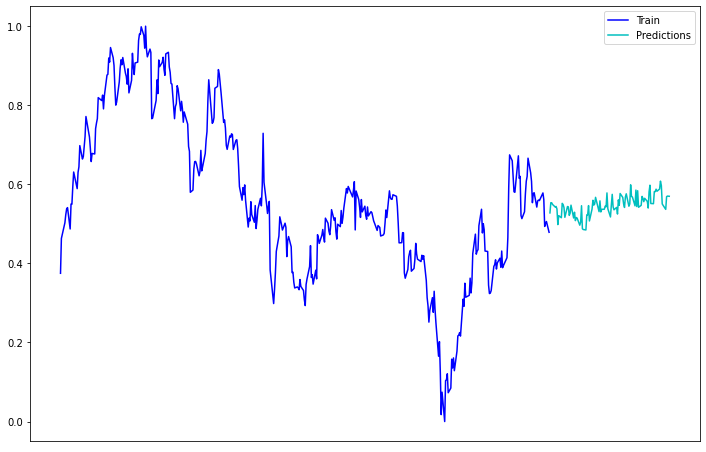

In [ ]:
# plotting the predictions as an extension of the training data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(yf_df)*0.2),int(len(yf_df)*0.4),int(len(yf_df)*0.6),int(len(yf_df)*0.8),int(len(yf_df))], labels = [yf_df.index[0],yf_df.index[int(len(yf_df)*0.2)],yf_df.index[int(len(yf_df)*0.4)],yf_df.index[int(len(yf_df)*0.6)],yf_df.index[int(len(yf_df)*0.8)], yf_df.index[-1]])
plt.plot(data_with_sent.ALXN[:int(len(data_with_sent["ALXN"])*0.8)], color = "b")
plt.plot(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

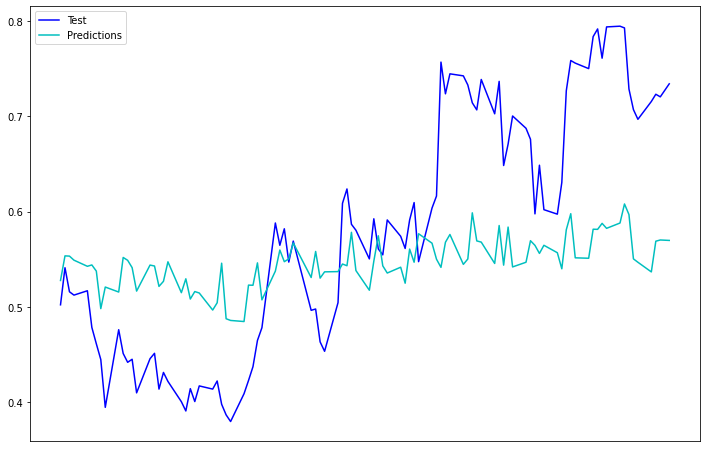

In [ ]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(y_test_sent)*0.2),int(len(y_test_sent)*0.4),int(len(y_test_sent)*0.6),int(len(y_test_sent)*0.8),int(len(y_test_sent))], labels = [y_test_sent.index[0],y_test_sent.index[int(len(y_test_sent)*0.2)],y_test_sent.index[int(len(y_test_sent)*0.4)],y_test_sent.index[int(len(y_test_sent)*0.6)],y_test_sent.index[int(len(y_test_sent)*0.8)], y_test_sent.index[-1]])
plt.plot(y_test_sent, color = "b")
plt.plot(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):] - y_test_sent)**2)

0.031162480710728285

# 3 Neural network for the articles with title text

In [ ]:
# creating a sequential model
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (61,100)))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

In [ ]:
# defining early stopping with the patience of 1 period
stop = EarlyStopping(monitor = "loss", patience = 1, mode = "min", restore_best_weights=True)
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model to the data
history = model.fit(X_train_titl, y_train_titl, epochs=50, batch_size=1, verbose=1, callbacks = [stop])

In [ ]:
# predicting the data
y_pred = model.predict(X_test_titl)

In [ ]:
# filling a column with missing values and the predictions
yf_df["pred"] = np.nan
yf_df["pred"][int(len(yf_df["ALXN"])*0.8):] = np.array(y_pred).squeeze(1)

In [ ]:
# plotting the predictions as an extension of the training data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(yf_df)*0.2),int(len(yf_df)*0.4),int(len(yf_df)*0.6),int(len(yf_df)*0.8),int(len(yf_df))], labels = [yf_df.index[0],yf_df.index[int(len(yf_df)*0.2)],yf_df.index[int(len(yf_df)*0.4)],yf_df.index[int(len(yf_df)*0.6)],yf_df.index[int(len(yf_df)*0.8)], yf_df.index[-1]])
plt.plot(yf_df.ALXN[:int(len(yf_df["ALXN"])*0.8)], color = "b")
plt.plot(yf_df["pred"][int(len(yf_df["ALXN"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_titl)*0.2),int(len(y_test_titl)*0.4),int(len(y_test_titl)*0.6),int(len(y_test_titl)*0.8),int(len(y_test_titl))], labels = [y_test_titl.index[0],y_test_titl.index[int(len(y_test_titl)*0.2)],y_test_titl.index[int(len(y_test_titl)*0.4)],y_test_titl.index[int(len(y_test_titl)*0.6)],y_test_titl.index[int(len(y_test_titl)*0.8)], y_test_titl.index[-1]])
plt.plot(y_test_titl, color = "b")
plt.plot(yf_df["pred"][int(len(yf_df["ALXN"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(yf_df["pred"][int(len(data_with_sent["ALXN"])*0.8):] - y_test_titl)**2)